In [1]:
import pandas as pd

df = pd.read_csv('data.csv')
df.head()

,world_idx,lidar_0,lidar_1,lidar_2,lidar_3,lidar_4,lidar_5,lidar_6,lidar_7,lidar_8,...,lidar_717,lidar_718,lidar_719,pos_x,pos_y,pose_heading,twist_linear,twist_angular,cmd_vel_linear,cmd_vel_angular
0,0,2.975122,2.950590,2.941146,2.934822,2.936081,2.940697,2.860065,2.844344,2.836783,...,2.939921,2.951161,2.975515,0.000410,0.000910,1.570855,0.009598,-0.002631,0.024,0.000042
1,0,2.972430,2.951944,2.938526,2.935578,2.935396,2.942980,2.860921,2.845748,2.834089,...,2.938502,2.952610,2.974882,0.000410,0.001337,1.570951,0.015093,0.003377,0.030,0.000042
2,0,2.972708,2.952116,2.939384,2.935842,2.935209,2.943959,2.859934,2.845049,2.835726,...,2.940752,2.950961,2.974894,0.000410,0.001885,1.570989,0.020909,0.005771,0.036,0.000088
3,0,2.971898,2.951548,2.941052,2.937054,2.937652,2.945617,2.860368,2.844340,2.837155,...,2.940525,2.952479,2.977302,0.000410,0.002582,1.571108,0.026900,0.012403,0.042,0.000088
4,0,2.973597,2.952102,2.938964,2.936647,2.938474,2.946904,2.860490,2.843487,2.837442,...,2.942413,2.950405,2.971989,0.000409,0.003343,1.571095,0.032934,0.012326,0.048,0.000088


In [2]:
df.describe()

,world_idx,lidar_0,lidar_1,lidar_2,lidar_3,lidar_4,lidar_5,lidar_6,lidar_7,lidar_8,...,lidar_717,lidar_718,lidar_719,pos_x,pos_y,pose_heading,twist_linear,twist_angular,cmd_vel_linear,cmd_vel_angular
count,197874.000000,197874.000000,197874.000000,197874.000000,197874.000000,197874.000000,197874.000000,197874.000000,197874.000000,197874.000000,...,197874.000000,197874.000000,197874.000000,197874.000000,197874.000000,197874.000000,197874.000000,197874.000000,197874.000000,197874.000000
mean,151.360037,4.078458,4.095890,4.116250,4.135100,4.152535,4.171141,4.187046,4.207134,4.228729,...,4.331385,4.313234,4.298415,-0.044590,4.085588,1.561297,0.704256,-0.001236,0.705201,-0.000337
std,86.694318,6.409648,6.468628,6.532197,6.592483,6.650592,6.708358,6.763005,6.821829,6.882105,...,7.022881,6.966949,6.914068,0.523861,2.800747,0.342559,0.211833,0.254823,0.208394,0.229899
min,0.000000,0.292501,0.290324,0.288359,0.288144,0.286397,0.283413,0.283495,0.281896,0.280428,...,0.289595,0.290922,0.219878,-1.706671,-0.000264,-3.141425,-0.314146,-2.183365,-0.300000,-1.570796
25%,77.000000,1.719141,1.713263,1.707765,1.701611,1.695104,1.691961,1.685540,1.679638,1.674704,...,1.623969,1.630992,1.637606,-0.304091,1.571724,1.471075,0.799498,-0.061546,0.800000,-0.066984
50%,153.000000,2.883244,2.869646,2.856122,2.842418,2.829051,2.815888,2.801626,2.787498,2.773753,...,2.822952,2.836291,2.850397,-0.006076,3.932725,1.580098,0.800230,-0.001608,0.800000,-0.000040
75%,227.000000,3.185827,3.170585,3.156329,3.141299,3.125171,3.110740,3.097386,3.083128,3.068944,...,3.142002,3.160312,3.177978,0.195552,6.489830,1.679653,0.801045,0.042874,0.800000,0.051272
max,299.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,...,30.000000,30.000000,30.000000,1.679888,9.359002,3.141587,0.811659,2.163897,0.800000,1.570796


In [3]:
# scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
columns = df.columns
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=columns)
df.head()

/home/jvthunder/anaconda/envs/mimic_data_extraction/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,world_idx,lidar_0,lidar_1,lidar_2,lidar_3,lidar_4,lidar_5,lidar_6,lidar_7,lidar_8,...,lidar_717,lidar_718,lidar_719,pos_x,pos_y,pose_heading,twist_linear,twist_angular,cmd_vel_linear,cmd_vel_angular
0,0.0,0.090301,0.089542,0.089284,0.089078,0.089174,0.089421,0.086705,0.086225,0.086016,...,0.089205,0.089543,0.092533,0.504076,0.000125,0.750003,0.287566,0.501634,0.294545,0.500013
1,0.0,0.090211,0.089588,0.089196,0.089104,0.089151,0.089498,0.086734,0.086272,0.085925,...,0.089158,0.089592,0.092511,0.504076,0.000171,0.750019,0.292447,0.503016,0.300000,0.500013
2,0.0,0.090220,0.089593,0.089225,0.089113,0.089145,0.089531,0.086701,0.086249,0.085980,...,0.089233,0.089536,0.092512,0.504075,0.000230,0.750025,0.297614,0.503567,0.305455,0.500028
3,0.0,0.090193,0.089574,0.089281,0.089153,0.089227,0.089586,0.086715,0.086225,0.086028,...,0.089226,0.089587,0.092593,0.504075,0.000304,0.750044,0.302935,0.505092,0.310909,0.500028
4,0.0,0.090250,0.089593,0.089211,0.089140,0.089255,0.089630,0.086719,0.086196,0.086038,...,0.089289,0.089518,0.092414,0.504075,0.000385,0.750042,0.308295,0.505074,0.316364,0.500028


In [4]:
# torch Dataset
import torch
from torch.utils.data import Dataset

class KULBarnDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.data = df
        self.data = self.data.drop(columns=['world_idx'])
        
        # get all the column values that contain the word lidar
        self.lidar_cols = [col for col in df.columns if 'lidar' in col]
        # get actions columns
        self.actions_cols = [col for col in df.columns if 'cmd' in col]
        # get other columns
        self.non_lidar_cols = [col for col in df.columns if col not in self.lidar_cols and col not in self.actions_cols]
        
        self.lidar_data = df[self.lidar_cols].values
        self.non_lidar_data = df[self.non_lidar_cols].values
        self.actions_data = df[self.actions_cols].values

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        lidar = self.lidar_data[idx]
        non_lidar = self.non_lidar_data[idx]
        actions = self.actions_data[idx]
        return lidar, non_lidar, actions

In [5]:
# split train and test
from sklearn.model_selection import train_test_split
import random

world_ids = [i for i in range(300)]
# select 0.8 of the world_ids as train_ids randomized
train_ids = random.sample(world_ids, 240)
test_ids = [id for id in world_ids if id not in train_ids]

train_df = df[df['world_idx'].isin(train_ids)]
test_df = df[df['world_idx'].isin(test_ids)]

train_dataset = KULBarnDataset(train_df)
test_dataset = KULBarnDataset(test_df)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 322
Test dataset size: 659


In [6]:
# dataloader
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# test dataloader
lidar, non_lidar, actions = next(iter(train_loader))
print(f"Lidar shape: {lidar.shape}")
# print size dataloader
print(f"Train loader size: {len(train_loader)}")
print(f"Test loader size: {len(test_loader)}")

Lidar shape: torch.Size([32, 720])
Train loader size: 11
Test loader size: 21


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class CNNModel(nn.Module):
    def __init__(self, num_lidar_features, num_non_lidar_features, num_actions):
        super(CNNModel, self).__init__()
        # Define the CNN for lidar data
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Flatten()
        )
        
        # Calculate the output size of the CNN
        cnn_output_size = self._get_cnn_output_size(num_lidar_features)
        
        # Define the fully connected layers for combined data
        self.fc = nn.Sequential(
            nn.Linear(cnn_output_size + num_non_lidar_features, 128),
            nn.ReLU(),
            nn.Linear(128, num_actions)
        )
        
    def _get_cnn_output_size(self, num_lidar_features):
        # Dummy input to calculate the output size of the CNN
        x = torch.zeros(1, 1, num_lidar_features)
        x = self.cnn(x)
        return x.size(1)

    def forward(self, lidar, non_lidar):
        lidar = lidar.unsqueeze(1)  # Add channel dimension
        lidar_features = self.cnn(lidar)
        combined_features = torch.cat((lidar_features, non_lidar), dim=1)
        actions = self.fc(combined_features)
        return actions

In [8]:
# Initialize the model
num_lidar_features = train_dataset.lidar_data.shape[1]
num_non_lidar_features = train_dataset.non_lidar_data.shape[1]
num_actions = train_dataset.actions_data.shape[1]
model = CNNModel(num_lidar_features, num_non_lidar_features, num_actions)

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Move the model and loss function to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)
print(device)

cpu


In [9]:
from tqdm import tqdm

def train_model(model, train_loader, loss_fn, optimizer):
    model.train()

    losses = []
    for lidar, non_lidar, actions in tqdm(train_loader):

        # Move the data to the device that is used
        lidar = lidar.to(device)
        non_lidar = non_lidar.to(device)
        actions = actions.to(device)

        # Forward pass
        actions_pred = model(lidar.float(), non_lidar.float())
        loss = loss_fn(actions_pred, actions.float())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save the loss
        losses.append(loss.item())

    # return the average loss for this epoch
    return sum(losses)/len(losses)

In [10]:
def test_model(model, test_loader, loss_fn):
    model.eval()

    losses = []
    for lidar, non_lidar, actions in tqdm(test_loader):
        # Move the data to the device that is used
        lidar = lidar.to(device)
        non_lidar = non_lidar.to(device)
        actions = actions.to(device)

        # Forward pass
        actions_pred = model(lidar.float(), non_lidar.float())
        loss = loss_fn(actions_pred, actions.float())

        # Save the loss
        losses.append(loss.item())

    # return the average loss for this epoch
    return sum(losses)/len(losses)

In [11]:
import sys
NUM_EPOCHS = 30

cnn_train_losses = []
cnn_test_losses = []
for epoch in range(NUM_EPOCHS):
    train_loss = train_model(model, train_loader, loss_fn, optimizer)
    test_loss = test_model(model, test_loader, loss_fn)
    cnn_train_losses.append(train_loss)
    cnn_test_losses.append(test_loss)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss} | Test Loss: {test_loss}")
    sys.stdout.flush()

100%|██████████| 21/21 [00:00<00:00, 433.24it/s]

Epoch 1/30 | Train Loss: 0.2947640933773734 | Test Loss: 0.10188476262348038



100%|██████████| 21/21 [00:00<00:00, 505.86it/s]

Epoch 2/30 | Train Loss: 0.07099218903617426 | Test Loss: 0.05222517994809009



100%|██████████| 21/21 [00:00<00:00, 432.28it/s]

Epoch 3/30 | Train Loss: 0.05103132738308473 | Test Loss: 0.08117215651907914



100%|██████████| 21/21 [00:00<00:00, 514.31it/s]

Epoch 4/30 | Train Loss: 0.04357777332717722 | Test Loss: 0.040097417598146765



100%|██████████| 21/21 [00:00<00:00, 454.42it/s]

Epoch 5/30 | Train Loss: 0.043866420672698456 | Test Loss: 0.03691883024848288



100%|██████████| 21/21 [00:00<00:00, 501.74it/s]

Epoch 6/30 | Train Loss: 0.037499883296814834 | Test Loss: 0.051027111819989625



100%|██████████| 21/21 [00:00<00:00, 453.62it/s]

Epoch 7/30 | Train Loss: 0.035096879794516346 | Test Loss: 0.06590550953877114



100%|██████████| 21/21 [00:00<00:00, 450.83it/s]

Epoch 8/30 | Train Loss: 0.03771314397454262 | Test Loss: 0.07384676193552357



100%|██████████| 21/21 [00:00<00:00, 384.16it/s]

Epoch 9/30 | Train Loss: 0.03343801691450856 | Test Loss: 0.0862244127118694



100%|██████████| 21/21 [00:00<00:00, 358.24it/s]

Epoch 10/30 | Train Loss: 0.03001061708412387 | Test Loss: 0.12252126974497168



100%|██████████| 21/21 [00:00<00:00, 326.88it/s]

Epoch 11/30 | Train Loss: 0.030665039338848808 | Test Loss: 0.1497777592213381



100%|██████████| 21/21 [00:00<00:00, 505.90it/s]

Epoch 12/30 | Train Loss: 0.02465054282749241 | Test Loss: 0.2239645147873532



100%|██████████| 21/21 [00:00<00:00, 506.05it/s]

Epoch 13/30 | Train Loss: 0.022688190706751564 | Test Loss: 0.3121820909991151



100%|██████████| 21/21 [00:00<00:00, 334.76it/s]

Epoch 14/30 | Train Loss: 0.021127682433209637 | Test Loss: 0.3708502246244323



100%|██████████| 21/21 [00:00<00:00, 470.15it/s]

Epoch 15/30 | Train Loss: 0.01788475108332932 | Test Loss: 0.45567064619223985



100%|██████████| 21/21 [00:00<00:00, 430.27it/s]

Epoch 16/30 | Train Loss: 0.018789169886572796 | Test Loss: 0.5657719829607577



100%|██████████| 21/21 [00:00<00:00, 498.65it/s]

Epoch 17/30 | Train Loss: 0.015144221526993946 | Test Loss: 0.7291372438360538



100%|██████████| 21/21 [00:00<00:00, 497.78it/s]

Epoch 18/30 | Train Loss: 0.013719148193062707 | Test Loss: 0.8158500318282417



100%|██████████| 21/21 [00:00<00:00, 301.70it/s]

Epoch 19/30 | Train Loss: 0.015271043997596611 | Test Loss: 0.9264696193415494



100%|██████████| 21/21 [00:00<00:00, 314.87it/s]

Epoch 20/30 | Train Loss: 0.011790468188172037 | Test Loss: 1.0757692259337222



100%|██████████| 21/21 [00:00<00:00, 291.40it/s]

Epoch 21/30 | Train Loss: 0.011023204011673277 | Test Loss: 1.1106774634016412



100%|██████████| 21/21 [00:00<00:00, 284.03it/s]

Epoch 22/30 | Train Loss: 0.010027289369397542 | Test Loss: 1.202932574741897



100%|██████████| 21/21 [00:00<00:00, 421.59it/s]

Epoch 23/30 | Train Loss: 0.009536802430044521 | Test Loss: 1.2337902607839732



100%|██████████| 21/21 [00:00<00:00, 447.39it/s]

Epoch 24/30 | Train Loss: 0.00954465407200835 | Test Loss: 1.342801306219328



100%|██████████| 21/21 [00:00<00:00, 370.35it/s]

Epoch 25/30 | Train Loss: 0.00836703312498602 | Test Loss: 1.3816887299042373



100%|██████████| 21/21 [00:00<00:00, 538.49it/s]

Epoch 26/30 | Train Loss: 0.008143521295013752 | Test Loss: 1.384901576631126



100%|██████████| 21/21 [00:00<00:00, 426.54it/s]

Epoch 27/30 | Train Loss: 0.007540492848916488 | Test Loss: 1.5481595707436402



100%|██████████| 21/21 [00:00<00:00, 453.30it/s]

Epoch 28/30 | Train Loss: 0.007215199505232952 | Test Loss: 1.5192512664056959



100%|██████████| 21/21 [00:00<00:00, 226.93it/s]

Epoch 29/30 | Train Loss: 0.0073873558589680624 | Test Loss: 1.548159060556264



100%|██████████| 21/21 [00:00<00:00, 204.21it/s]

Epoch 30/30 | Train Loss: 0.008940455376763235 | Test Loss: 1.6550090660651524


In [12]:
# plot the loss
import matplotlib.pyplot as plt

plt.plot(cnn_train_losses, label='Train Loss')
plt.plot(cnn_test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show();

<Figure size 640x480 with 1 Axes>

In [13]:
# save the model
torch.save(model.state_dict(), 'cnn_model.pth')

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

class TransformerModel(nn.Module):
    def __init__(self, num_lidar_features, num_non_lidar_features, num_actions, d_model=64, nhead=8, num_encoder_layers=3, num_decoder_layers=3):
        super(TransformerModel, self).__init__()

        self.d_model = d_model
        self.num_patches = 20  # Number of patches
        self.patch_size = num_lidar_features // self.num_patches

        # Positional Encoding for the Encoder
        self.positional_encoding = nn.Parameter(torch.zeros(self.num_patches, d_model))

        # Input Embedding for Encoder (LiDAR data)
        self.lidar_embedding = nn.Linear(self.patch_size, d_model)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        # Input Embedding for Decoder (Non-LiDAR data)
        self.non_lidar_embedding = nn.Linear(num_non_lidar_features, d_model)

        # Transformer Decoder
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        # Linear layer to map the transformer output to actions
        self.fc_out = nn.Linear(d_model, num_actions)

    def forward(self, lidar, non_lidar):
        batch_size = lidar.size(0)
        
        # Divide LiDAR input into patches
        lidar_patches = lidar.view(batch_size, self.num_patches, self.patch_size)

        # Embed each patch and add positional encoding
        lidar_embed = self.lidar_embedding(lidar_patches) + self.positional_encoding.unsqueeze(0)
        lidar_embed = lidar_embed.permute(1, 0, 2)  # Convert to (seq_len, batch_size, d_model)

        # Process through the transformer encoder
        memory = self.transformer_encoder(lidar_embed)

        # Process non-lidar data through input embedding
        non_lidar_embed = self.non_lidar_embedding(non_lidar).unsqueeze(0)  # Convert to (1, batch_size, d_model)

        # Process through the transformer decoder
        output = self.transformer_decoder(non_lidar_embed, memory)

        # Final linear layer to get the actions
        actions = self.fc_out(output.squeeze(0))
        return actions

In [15]:
# Initialize the model
num_lidar_features = train_dataset.lidar_data.shape[1]
num_non_lidar_features = train_dataset.non_lidar_data.shape[1]
num_actions = train_dataset.actions_data.shape[1]
model = TransformerModel(num_lidar_features, num_non_lidar_features, num_actions)

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Move the model and loss function to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)
print(device)

cpu


In [16]:
import sys
NUM_EPOCHS = 30

transformer_train_losses = []
transformer_test_losses = []
for epoch in range(NUM_EPOCHS):
    train_loss = train_model(model, train_loader, loss_fn, optimizer)
    test_loss = test_model(model, test_loader, loss_fn)
    transformer_train_losses.append(train_loss)
    transformer_test_losses.append(test_loss)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss} | Test Loss: {test_loss}")
    sys.stdout.flush()

100%|██████████| 21/21 [00:00<00:00, 103.15it/s]

Epoch 1/30 | Train Loss: 0.4105431613597003 | Test Loss: 0.03191988170146942



100%|██████████| 21/21 [00:00<00:00, 77.58it/s]

Epoch 2/30 | Train Loss: 0.09570641747929833 | Test Loss: 0.0373991612522375



100%|██████████| 21/21 [00:00<00:00, 101.22it/s]

Epoch 3/30 | Train Loss: 0.06136417930776423 | Test Loss: 0.01526665253221013



100%|██████████| 21/21 [00:00<00:00, 100.92it/s]

Epoch 4/30 | Train Loss: 0.051497817378152504 | Test Loss: 0.027957573643929902



100%|██████████| 21/21 [00:00<00:00, 101.41it/s]

Epoch 5/30 | Train Loss: 0.05313330177556385 | Test Loss: 0.01614648725704423



100%|██████████| 21/21 [00:00<00:00, 100.26it/s]

Epoch 6/30 | Train Loss: 0.05038977211171931 | Test Loss: 0.026840641163289547



100%|██████████| 21/21 [00:00<00:00, 101.32it/s]

Epoch 7/30 | Train Loss: 0.05250313200733878 | Test Loss: 0.018213467788882554



100%|██████████| 21/21 [00:00<00:00, 109.77it/s]

Epoch 8/30 | Train Loss: 0.044820570132949135 | Test Loss: 0.020925568084099462



100%|██████████| 21/21 [00:00<00:00, 103.93it/s]

Epoch 9/30 | Train Loss: 0.042586587708104744 | Test Loss: 0.03154175246267447



100%|██████████| 21/21 [00:00<00:00, 104.41it/s]

Epoch 10/30 | Train Loss: 0.04354833388193087 | Test Loss: 0.030297277827880213



100%|██████████| 21/21 [00:00<00:00, 109.42it/s]

Epoch 11/30 | Train Loss: 0.038432441651821136 | Test Loss: 0.020731469621837494



100%|██████████| 21/21 [00:00<00:00, 100.69it/s]

Epoch 12/30 | Train Loss: 0.027527313594791023 | Test Loss: 0.040094316560065464



100%|██████████| 21/21 [00:00<00:00, 101.37it/s]

Epoch 13/30 | Train Loss: 0.02859997224401344 | Test Loss: 0.032210911540979784



100%|██████████| 21/21 [00:00<00:00, 103.01it/s]

Epoch 14/30 | Train Loss: 0.02656585215167566 | Test Loss: 0.07166731428532373



100%|██████████| 21/21 [00:00<00:00, 96.80it/s] 

Epoch 15/30 | Train Loss: 0.022140538827939468 | Test Loss: 0.07831655813026286



100%|██████████| 21/21 [00:00<00:00, 105.97it/s]

Epoch 16/30 | Train Loss: 0.02418196015059948 | Test Loss: 0.06605017726265248



100%|██████████| 21/21 [00:00<00:00, 108.13it/s]

Epoch 17/30 | Train Loss: 0.018540841273286125 | Test Loss: 0.0628840691531964



100%|██████████| 21/21 [00:00<00:00, 105.92it/s]

Epoch 18/30 | Train Loss: 0.019307792271402748 | Test Loss: 0.06744930732418739



100%|██████████| 21/21 [00:00<00:00, 110.06it/s]

Epoch 19/30 | Train Loss: 0.018630870363929054 | Test Loss: 0.050876345862412735



100%|██████████| 21/21 [00:00<00:00, 105.18it/s]

Epoch 20/30 | Train Loss: 0.01783821077763357 | Test Loss: 0.047806817949527784



100%|██████████| 21/21 [00:00<00:00, 105.55it/s]

Epoch 21/30 | Train Loss: 0.018812558275054802 | Test Loss: 0.05210507621190378



100%|██████████| 21/21 [00:00<00:00, 107.25it/s]

Epoch 22/30 | Train Loss: 0.019221695224669846 | Test Loss: 0.05367432307684794



100%|██████████| 21/21 [00:00<00:00, 103.24it/s]

Epoch 23/30 | Train Loss: 0.01606017080220309 | Test Loss: 0.0736311063547397



100%|██████████| 21/21 [00:00<00:00, 105.88it/s]

Epoch 24/30 | Train Loss: 0.01557735400274396 | Test Loss: 0.08941901855481167



100%|██████████| 21/21 [00:00<00:00, 107.61it/s]

Epoch 25/30 | Train Loss: 0.01645723544061184 | Test Loss: 0.09440728066311706



100%|██████████| 21/21 [00:00<00:00, 117.21it/s]

Epoch 26/30 | Train Loss: 0.01502262432636185 | Test Loss: 0.047578471357978526



100%|██████████| 21/21 [00:00<00:00, 96.57it/s]

Epoch 27/30 | Train Loss: 0.015328390357105738 | Test Loss: 0.0470898087812765



100%|██████████| 21/21 [00:00<00:00, 106.40it/s]

Epoch 28/30 | Train Loss: 0.016799425706267357 | Test Loss: 0.07262100104153865



100%|██████████| 21/21 [00:00<00:00, 107.73it/s]

Epoch 29/30 | Train Loss: 0.01526627494868907 | Test Loss: 0.06299568994325541



100%|██████████| 21/21 [00:00<00:00, 95.18it/s]

Epoch 30/30 | Train Loss: 0.01511001523414796 | Test Loss: 0.08122097452481587


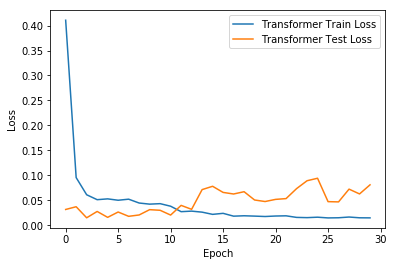

In [17]:
# plot the loss
import matplotlib.pyplot as plt

plt.plot(transformer_train_losses, label='Transformer Train Loss')
plt.plot(transformer_test_losses, label='Transformer Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [18]:
# save the model
torch.save(model.state_dict(), 'transformer_model.pth')